In [1]:
#!/usr/bin/env python
import glob
import numpy as np
from operator import itemgetter
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense
from keras import optimizers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

/home/cloud/code/virtualenvs/inverse_model/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
training_files = sorted(glob.glob('data/data_*'))
#training_files = ['data/data_5']
model_file = 'weights/ForwardModel.h5'
inverse_model_file = 'weights/InverseModelCombined.h5'

# Load the model
forwardModel = load_model(model_file)

# Load each data file into quasi-3D structure, note, since axis1 varies in length
# it is a list of 2D numpy arrays, this is resolved below with padding
training_data = [np.loadtxt(f ,delimiter=',',skiprows=1) for f in training_files]

for i in range(len(training_data)):
    print training_files[i], ":", training_data[i].shape 
    
# Create blank 2D array with 'outside' shape equal to that of data
input_training_data_n = [[]]*len(training_data)

# Get max length, to pad the other trajectories with 0s
max_len = max([td.shape for td in training_data],key=itemgetter(0))[0]
print(max_len)
# Cube positions
p_cube1 = [0.18529411764705872, -0.46270270270270264,-0.07]
p_cube2 = [-0.17867647058823533, -0.47783783783783784,-0.07]
p_cube3 = [0.1874999999999999, -0.6983783783783784,-0.07]
p_cube4 = [-0.17647058823529416, -0.7027027027027026,-0.07]

# Cube order matches that of trajectories in data files
p_cubes = np.array([p_cube1, p_cube3, p_cube2, p_cube4])

# Delete columns for time, frozen joints, gripper
out_tr_dat = [np.delete(data,[0,3,7,8],axis=1) for data in training_data]

# Build input data for Inverse Model based on Forward Model predictions
for i in range(len(training_files)):
    input_training_data_n[i] = []
    for j in out_tr_dat[i]:
        prediction = forwardModel.predict(np.array([j]))
        input_training_data_n[i].append(prediction - p_cubes[i])
    # Concate to reduce redundant dimension, i.e. [[x,y,z]] -> [x,y,z]
    input_training_data_n[i] = np.copy(np.concatenate(input_training_data_n[i]))
    # Pads trajectories with less steps than the highest count trajectory, pads bottom with zero
    input_training_data_n[i] = np.pad(input_training_data_n[i], 
                                      ((0, max_len - len(input_training_data_n[i])), (0,0)), 'constant', constant_values=np.nan)

for i in range(len(out_tr_dat)):
    out_tr_dat[i] = np.pad(out_tr_dat[i], ((0, max_len - len(out_tr_dat[i])), (0,0)), 'constant', constant_values=np.nan)

out_tr_dat = np.array(out_tr_dat)
input_training_data_n = np.array(input_training_data_n)
print(out_tr_dat.shape)
print(input_training_data_n.shape)

data/data_5 : (1081, 9)
data/data_6 : (1204, 9)
data/data_7 : (1147, 9)
data/data_8 : (1275, 9)
1275
(4, 1275, 5)
(4, 1275, 3)


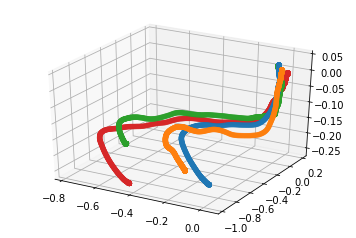

In [3]:
# Plot the trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for data in input_training_data_n: 
    X = -data[:,0]
    Y = -data[:,1]
    Z = -data[:,2]

    surf = ax.scatter(X, Y, Z)

plt.show()

In [4]:
# Define the Inverse Model
InverseModel = Sequential()
InverseModel.add(Dense(200, activation="sigmoid", kernel_initializer="uniform", input_shape=(6,)))
InverseModel.add(Dense(200, activation="sigmoid", kernel_initializer="uniform"))
InverseModel.add(Dense(5))
InverseModel.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [5]:
# Define the final input and output data, must delete last entries to preserve shape when concatenating
input_training_data = input_training_data_n[:,:-1]
out_tr_dat = out_tr_dat[:,1:]

input_training_data_t = np.concatenate((input_training_data_n[:,[0]], input_training_data_n[:,:-2]), axis=1)

# This will will expand the shape of the input data by two on the 2nd axis.
# Forming a table with:
#     PREV           NEXT
# x_0, y_0, z_0, x_0, y_0, z_0 
# x_1, y_1, z_1, x_0, y_0, z_0
# . . 
input_training_combined = np.concatenate((input_training_data, input_training_data_t), axis=2)

# Merge outer axis (files) into 2D.
out_tr_dat = np.concatenate(out_tr_dat)
input_training_combined = np.concatenate(input_training_combined)

axv = 0
if len(training_files) == 1:
    axv = None
    
# Remove isnan entries. 
nan_out = np.unique(np.argwhere(np.isnan(out_tr_dat))[:,0], axis=axv)
out_tr_dat = np.delete(out_tr_dat, nan_out, 0)
input_training_combined = np.delete(input_training_combined, nan_out, 0)

In [6]:
# Train the Model
history = InverseModel.fit(input_training_combined,out_tr_dat,batch_size=1, epochs=2)
InverseModel.save(inverse_model_file)

Epoch 1/2
4703/4703 [==============================] - 19s 4ms/step - loss: 0.0580 - acc: 0.9998
Epoch 2/2
4703/4703 [==============================] - 19s 4ms/step - loss: 0.0351 - acc: 1.0000


In [7]:
def plotperformance(history):
    range_epochs = range(0, len(history[history.keys()[0]]))
    plt.figure()
    plt.title("performance")
    plt.xlabel("epoch")
    plt.ylabel("loss/accuracy")
    plt.ylim(0, 1)
    for res in history.keys():
        plt.plot(range_epochs, history[res], label=res)
    plt.legend(loc='upper right')
    plt.show()

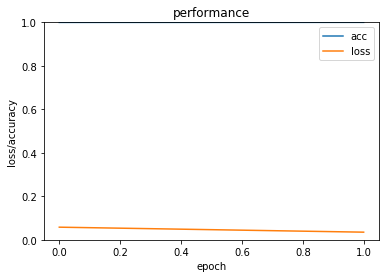

In [8]:
plotperformance(history.history)

In [9]:
if False != False: # ;), if X_Test  and y_Test are defined this will plot receiver operator characteristic
    scores = model.evaluate(X_Test, y_Test)
    print scores

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_Test, model.predict(X_Test))
                        
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()